# <center>UrbanSound8K</center>

## Libraries Import

In [27]:
import os
import math
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics
import mlflow.pytorch
import torchaudio
import torchaudio.transforms as transforms
from random import randint
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Parameters

In [28]:
########################################################################
dataset_path = "dataset"
########################################################################
# Choose the device to operate on
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Used device: {device}")
########################################################################
# Transforms parameters
target_sample_rate = 22050
target_event_length = 4
n_fft = 1024
hop_length = 512
f_max = 8000
n_mels = 64
n_frames = (target_sample_rate * target_event_length) // hop_length + 1
transforms_params = {
    "target_sample_rate" : target_sample_rate,
    "target_event_length" : target_event_length,
    "n_fft" : n_fft,
    "hop_length" : hop_length,
    "f_max" : f_max,
    "n_mels" : n_mels
}

Used device: cuda


## Import of the Metadata File

In [29]:
metadata = pd.read_csv("dataset/UrbanSound8K.csv")
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


## Creation of the Dataset Class

In [30]:
class UrbanSound8K(Dataset):
    
    def __init__(self, metadata, dataset_path, transforms_params, device):
        self.device = device
        self.metadata = metadata
        self.dataset_path = dataset_path
        self.n_folds = max(metadata["fold"])
        self.target_sample_rate = transforms_params["target_sample_rate"]
        self.target_event_length = transforms_params["target_event_length"]
        self.num_samples = target_event_length * target_sample_rate
        self.n_fft = transforms_params["n_fft"]
        self.hop_length = transforms_params["hop_length"]
        self.f_max = transforms_params["f_max"]
        self.n_mels = transforms_params["n_mels"]
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        label = torch.tensor(self._get_event_class(index), dtype=torch.long)
        signal, sr = self._get_event_signal(index)
        signal = signal.to(self.device)
        signal = self._mix_down_if_necessary(signal)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self._spectrogram_transform(signal)
        signal = self._db_transform(signal)
        return signal, label
    
    def _get_event_class(self, index):
        return self.metadata.iloc[index]["classID"]
    
    def _get_event_signal(self, index):
        event_fold = f"fold{self.metadata.iloc[index]['fold']}"
        event_filename = self.metadata.iloc[index]["slice_file_name"]
        audio_path = os.path.join(self.dataset_path, event_fold, event_filename)
        signal, sr = torchaudio.load(audio_path)
        return signal, sr
    
    def _mix_down_if_necessary(self, signal):
        # If signal has multiple channels, mix down to mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resample_transform = resample_transform.to(self.device)
            signal = resample_transform(signal)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
        
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _spectrogram_transform(self, signal):
        mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
                                                        sample_rate = self.target_sample_rate,
                                                        n_fft = self.n_fft,
                                                        hop_length = self.hop_length,
                                                        f_max = self.f_max,
                                                        n_mels = self.n_mels,
                                                        power = 2,
                                                        normalized=True
                                                        )      
        mel_spectrogram_transform = mel_spectrogram_transform.to(self.device)
        signal = mel_spectrogram_transform(signal)
        return signal
    
    def _db_transform(self, signal):
        db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")
        db_transform = db_transform.to(self.device)
        signal = db_transform(signal)
        return signal
        

## Instantiation of the Dataset

In [31]:
# Instantiate a dataset object
dataset = UrbanSound8K(
    metadata=metadata, 
    dataset_path=dataset_path, 
    transforms_params=transforms_params,
    device=device
)

## Dataset Exploration

### Classes Counts

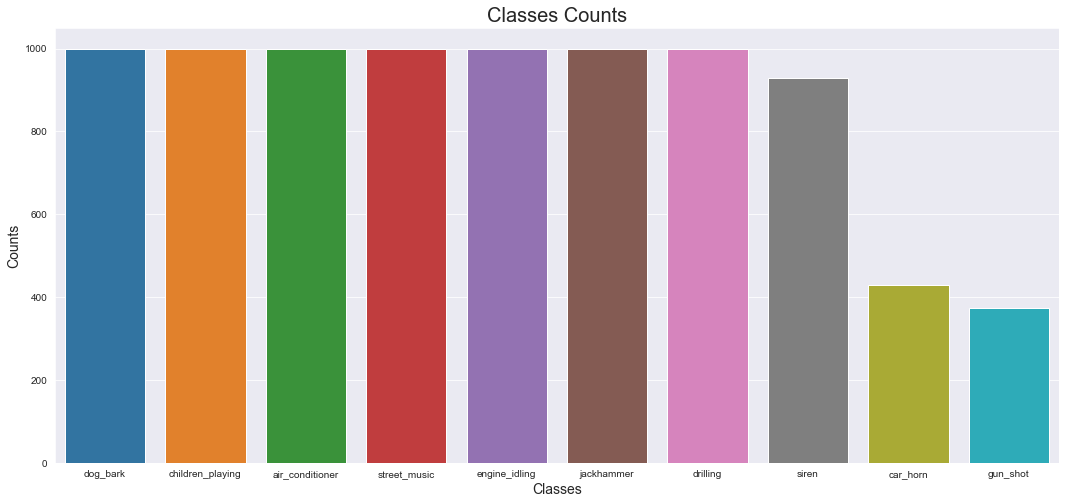

In [32]:
class_vc = dataset.metadata["class"].value_counts()
plt.figure(figsize=(18,8))
sns.barplot(x=class_vc.index, y=class_vc.values)
plt.title("Classes Counts", fontsize=20)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

### Duration of Events

Text(0, 0.5, 'Counts')

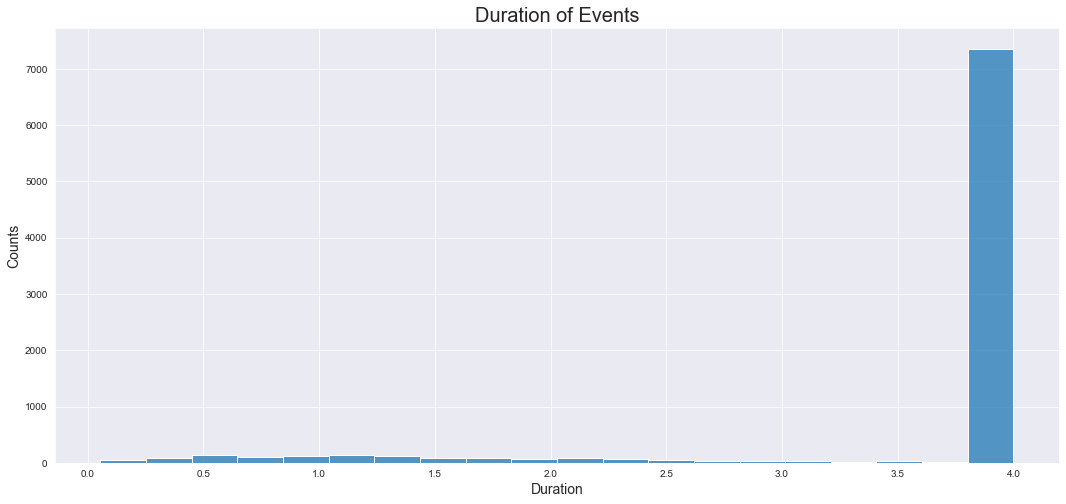

In [33]:
duration = dataset.metadata["end"] - dataset.metadata["start"]
plt.figure(figsize=(18,8))
sns.histplot(data=duration, x=duration.values, bins=20)
plt.title("Duration of Events", fontsize=20)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Counts", fontsize=14)

### Salience

#### Global

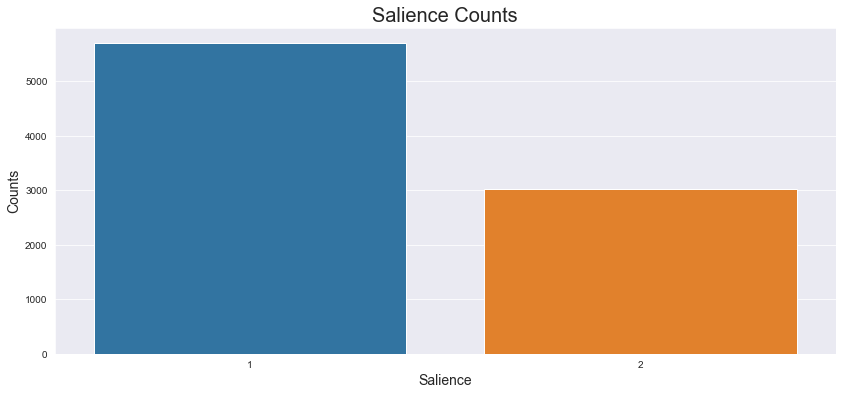

In [34]:
salience_vc = dataset.metadata["salience"].value_counts()
plt.figure(figsize=(14,6))
sns.barplot(x=salience_vc.index, y=salience_vc.values)
plt.title("Salience Counts", fontsize=20)
plt.xlabel("Salience", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

#### Per Class

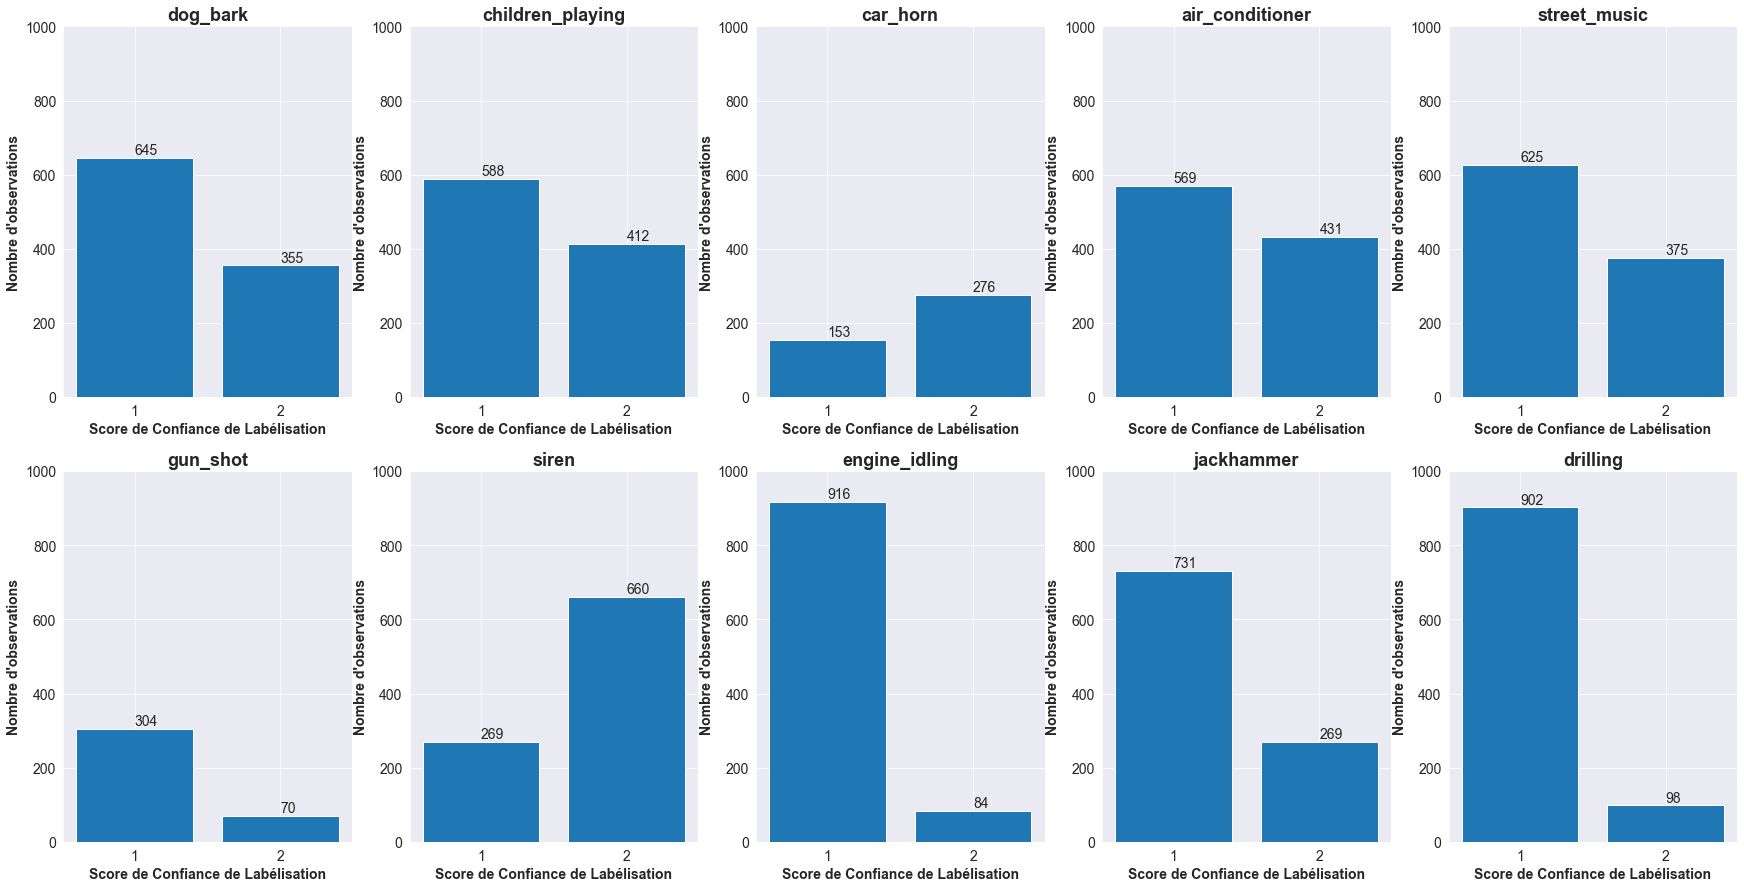

In [35]:
# Set subplot figure parameters
n_cols = 5
n_rows = math.ceil(len(metadata["class"].unique())/n_cols) # Compute the number of rows based on the number of labels and columns
p_count = 1

fig = plt.figure(figsize=(30,15))

# For each unique class
for unique_class in metadata["class"].unique():
    # Filter the metadata based on the label
    filtered_metadata = metadata[metadata["class"]==unique_class]
    # Initialize a dictionnary to count the number events for each salience score
    salience_dict = {1:0, 2:0}
    # For each row of the filtered metadata
    for index, row in filtered_metadata.iterrows():
        # Get the salience score
        salience_score = row[4]
        # Populate the dictionnary
        if salience_score not in salience_dict:
            salience_dict[salience_score] = 1
        else:
            salience_dict[salience_score] += 1
    plt.subplot(n_rows, n_cols, p_count) 
    # Plot a bar graph with all salience scores on the x axis
    plt.bar(range(len(salience_dict)), list(salience_dict.values()), align='center')
    plt.ylim([0, 1000])
    # Write the counts on each bar
    for salience in salience_dict.keys():
        plt.text(salience-1, (filtered_metadata['salience'] == salience).sum()+10, str((filtered_metadata['salience'] == salience).sum()), fontsize=14)
    # Write the ticks on the x axis
    plt.xticks(range(len(salience_dict)), list(salience_dict.keys()), fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"{unique_class}", fontweight="bold", fontsize=18)
    plt.xlabel("Score de Confiance de Labélisation", fontweight="bold", fontsize=14)
    plt.ylabel("Nombre d'observations", fontweight="bold", fontsize=14)
    p_count += 1

plt.show()

### Folds Distribution

In [36]:
# Group by fold and label and pivot
folds_vc = metadata.groupby(["fold", "class"], dropna=False, as_index=False)["class"].size()
folds_vc.pivot(index="class", columns="fold", values="size")

fold,1,2,3,4,5,6,7,8,9,10
class,,,,,,,,,,
air_conditioner,100,100,100,100,100,100,100,100,100,100
car_horn,36,42,43,59,98,28,28,30,32,33
children_playing,100,100,100,100,100,100,100,100,100,100
dog_bark,100,100,100,100,100,100,100,100,100,100
drilling,100,100,100,100,100,100,100,100,100,100
engine_idling,96,100,107,107,107,107,106,88,89,93
gun_shot,35,35,36,38,40,46,51,30,31,32
jackhammer,120,120,120,120,120,68,76,78,82,96
siren,86,91,119,166,71,74,77,80,82,83


### Visualition of an Event

,slice_file_name,fsID,start,end,salience,fold,classID,class
3597,174284-6-2-0.wav,174284,5.175802,8.181107,1,7,6,gun_shot


tensor([[ -62.8089,  -59.3279,  -36.2461,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -60.6747,  -60.8968,  -32.3554,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -53.2831,  -63.5657,  -27.0654,  ..., -100.0000, -100.0000,
         -100.0000],
        ...,
        [ -83.0683,  -84.6331,  -22.3042,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -85.5116,  -83.8268,  -20.1061,  ..., -100.0000, -100.0000,
         -100.0000],
        [ -80.5454,  -80.9317,  -21.1509,  ..., -100.0000, -100.0000,
         -100.0000]])
tensor(-1.3986)
tensor(-100.)


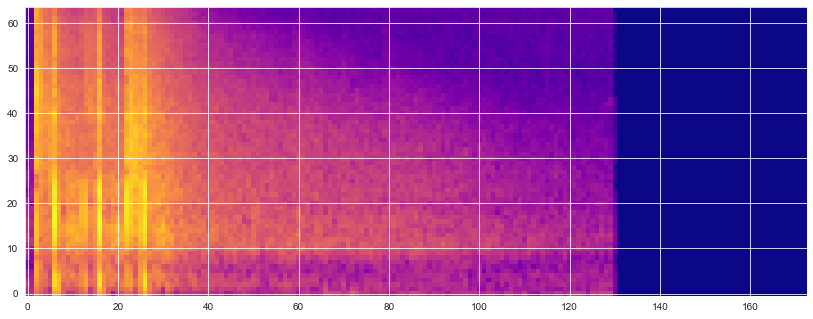

In [37]:
# Input annotations filtering critera
label = "gun_shot"
salience = 1 

# Filter annotations based on criteria
filtered_metadata = dataset.metadata.loc[
    (metadata["class"]==label)
    & (metadata["salience"]==salience)
    ]

# Randomly select the desired number of events from the filtered annotations
selected_event = filtered_metadata.sample(n=1) 
display(selected_event)
selected_event_index = selected_event.index.item()

spectrogram, label = dataset[selected_event_index]

spectrogram = spectrogram.cpu()
spectrogram = torch.squeeze(spectrogram)

print(spectrogram)
print(spectrogram.max())
print(spectrogram.min())

plt.figure(figsize=(14,14))
plt.imshow(spectrogram, origin="lower", cmap='plasma')

# Build the audio path
selected_event_fold = f"fold{selected_event.iloc[0]['fold']}"
selected_event_filename = selected_event.iloc[0]["slice_file_name"]
selected_audio_path = os.path.join(dataset_path, selected_event_fold, selected_event_filename)
display(IPython.display.Audio(filename=selected_audio_path))

## Creation of the Model

In [38]:
class SoundClassifierPL(pl.LightningModule):
    def __init__(self, num_classes, lr):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 12, num_classes)
        
        self.lr = lr
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        
    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
            
    def training_step(self, train_batch, batch_idx):
        inputs, targets = train_batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        self.train_acc(logits, targets)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", self.train_acc, on_step=True, on_epoch=False)
        return loss
    
    def validation_step(self, validation_batch, batch_idx):
        inputs, targets = validation_batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        self.val_acc(logits, targets)
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_acc", self.val_acc, on_step=True, on_epoch=True)
        return loss

## Model Training and Validation

In [ ]:
num_classes = len(dataset.metadata["class"].unique())

for i in range(1,dataset.n_folds+1):
    
    print(f"========== Cross-validation {i} on {dataset.n_folds} ==========")
    
    # Get the train and validation sets
    train_metadata = dataset.metadata.drop(dataset.metadata[dataset.metadata["fold"]==i].index)
    validation_metadata = dataset.metadata[dataset.metadata["fold"]==i]
    train_indices = train_metadata.index
    validation_indices = validation_metadata.index 
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SequentialSampler(validation_indices)
    
    # Create the train and validation dataloaders
    train_dataloader = DataLoader(
                            dataset, 
                            batch_size=100, 
                            sampler=train_sampler,
                            )
    
    validation_dataloader = DataLoader(
                            dataset, 
                            batch_size=100,
                            sampler=validation_sampler,
                            )

    # Instantiate the model pipeline
    model = SoundClassifierPL(num_classes, lr=1e-4)
    
    early_stopping = EarlyStopping(
                        monitor="val_loss",
                        patience=3
                    )
    
    # Instantiate the trainer and train the model
    trainer = Trainer(
                        gpus=-1,
                        max_epochs=20, 
                        check_val_every_n_epoch=1,
                        log_every_n_steps = 50,
                        callbacks=[early_stopping]
                    )
   
    mlflow.pytorch.autolog()

    run_name = f"{dataset.n_folds} folds cross-validation - Validation on fold {i}"
    
    with mlflow.start_run(run_name=run_name) as run:
        trainer.fit(model, train_dataloader, validation_dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2021/12/17 16:36:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | conv1     | Sequential | 160   
1 | conv2     | Sequential | 4.6 K 
2 | conv3     | Sequential | 18.5 K
3 | conv4     | Sequential | 73.9 K
4 | flatten   | Flatten    | 0     
5 | linear    | Linear     | 76.8 K
6 | train_acc | Accuracy   | 0     
7 | val_acc   | Accuracy   | 0     
-----------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.696     Total estimated model params size (MB)


========== Cross-validation 1 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

C:\Users\APU\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2021/12/17 16:36:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | conv1     | Sequential | 160   
1 | conv2     | Sequential | 4.6 K 
2 | conv3     | Sequential | 18.5 K
3 | conv4     | Sequential | 73.9 K
4 | flatten   | Flatten    | 0     
5 | linear    | Linear     | 76.8 K
6 | train_acc | Accuracy   | 0     
7 | val_acc   | Accuracy   | 0     
--------

========== Cross-validation 2 on 10 ==========


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]